In [74]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import sys 
import math

In [76]:
data = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/data.dat')[:,:2]
rand = np.loadtxt('/home/echeveste/mis_trabajos/correlation_f_2/datos/dat_glx/rand0.dat')[:,:2]

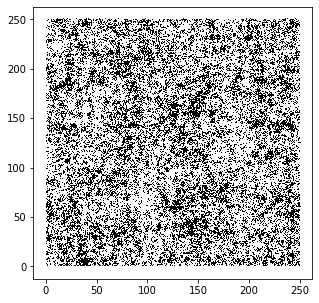

In [68]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[:,0],data[:,1],'k,')

In [69]:
tam = 15
x = [i for i in range(math.floor(np.min(data[:,0])),math.ceil(np.max(data[:,0]))+tam,tam)]
y = [i for i in range(math.floor(np.min(data[:,1])),math.ceil(np.max(data[:,1]))+tam,tam)]

In [70]:
x_ = math.ceil((math.ceil(np.max(data[:,0])) - math.floor(np.min(data[:,0])))/tam)
y_ = math.ceil((math.ceil(np.max(data[:,1])) - math.floor(np.min(data[:,1])))/tam)

In [71]:
mallas = []
for i in range(len(x)-1):
    for j in range(len(y)-1):
        mallas.append(data[(data[:,0]>x[i])&(data[:,0]<x[i+1])&(data[:,1]>y[j])&(data[:,1]<y[j+1])])

In [72]:
puntom = []
pm = tam/2
for i in range(int(np.sqrt(len(mallas)))):
    for j in range(int(np.sqrt(len(mallas)))):
        puntom.append([(tam/2)+i*tam,(tam/2)+j*tam])
puntom = np.array(puntom)

(-10.0, 260.0)

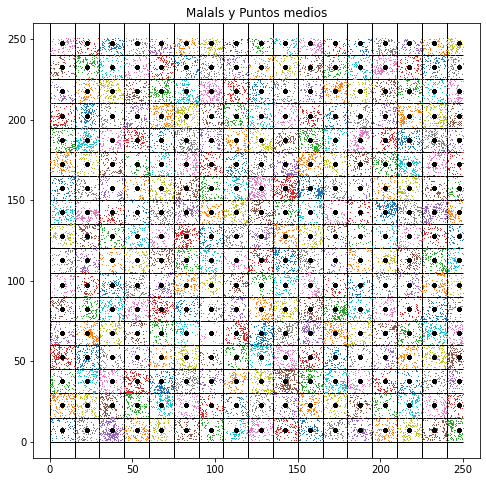

In [73]:
fig = plt.figure(figsize=(8,8))
plt.title('Malals y Puntos medios')
for i in range(len(mallas)):
    plt.plot(mallas[i][:,0],mallas[i][:,1],',')
    plt.plot(puntom[:,0],puntom[:,1],'k.')
    if i <= 250/tam:
        plt.axvline(i*tam,ymin=0, ymax = 250, linewidth=1, color = 'k')
        plt.hlines(i*tam, xmin=0, xmax=250, linewidth=1, color = 'k')
plt.xlim(-10,260)
plt.ylim(-10,260)

<ipython-input-89-f5841e63ba36>:8: RuntimeWarning: divide by zero encountered in true_divide
  m = np.abs(dy/dx)


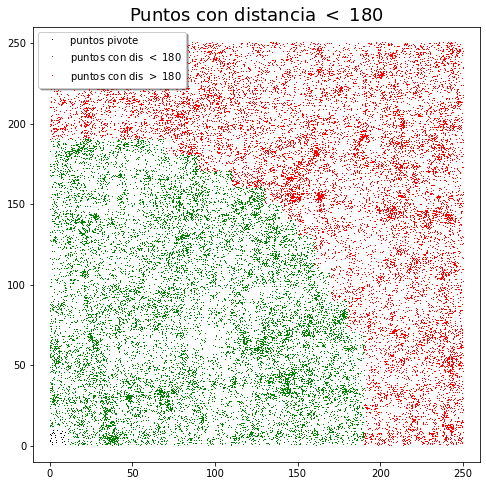

In [89]:
i = 0
dis_max = 180

pm = tam/2
s = puntom[i]-puntom[i+1:] 
dx = puntom[i][0]-puntom[i+1:][:,0]
dy = puntom[i][1]-puntom[i+1:][:,1]
m = np.abs(dy/dx)
dis = np.zeros_like(s[:,0])
dis[m<1] = np.sqrt(s[m<1][:,0]**2+s[m<1][:,1]**2)*(1-(2*pm/np.abs(dx[m<1])))
dis[m>1] = np.sqrt(s[m>1][:,0]**2+s[m>1][:,1]**2)*(1-(2*pm/np.abs(dy[m>1])))
dis[m==1.] = np.sqrt(s[m==1.][:,0]**2+s[m==1.][:,1]**2)-(2*pm*np.sqrt(2))

pp =np.concatenate(np.array(mallas[i+1:],dtype=object)[dis<dis_max])
pp_ =np.concatenate(np.array(mallas[i+1:],dtype=object)[dis>=dis_max])

fig = plt.figure(figsize=(8,8))
plt.plot(mallas[i][:,0],mallas[i][:,1],'k,',label='puntos pivote')
plt.plot(pp[:,0],pp[:,1],'g,',label='puntos con dis $<$ {0}'.format(dis_max))
plt.plot(pp_[:,0],pp_[:,1],'r,',label='puntos con dis $>$ {0}'.format(dis_max))
plt.xlim(-10,260)
plt.ylim(-10,260)
plt.title('Puntos con distancia $<$ {0}'.format(dis_max),fontsize=18)
plt.legend(shadow=True, fontsize='10')

# PRUEBA

In [47]:
def subdiv(data,tam):
    x = [i for i in range(math.floor(np.min(data[:,0])),math.ceil(np.max(data[:,0]))+tam,tam)]
    y = [i for i in range(math.floor(np.min(data[:,1])),math.ceil(np.max(data[:,1]))+tam,tam)]
    malla = []
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            malla.append(data[(data[:,0]>x[i])&(data[:,0]<x[i+1])&(data[:,1]>y[j])&(data[:,1]<y[j+1])])
    
    puntom = []
    dpm = tam/2
    for i in range(int(np.sqrt(len(malla)))):
        for j in range(int(np.sqrt(len(malla)))):
            puntom.append([dpm+i*tam, dpm+j*tam])
    
    puntom = np.array(puntom)
    
    return malla, puntom, dpm

In [48]:
def Histo_ani_XX(p,bn,point_max):
    
    # Iniciamos los arreglos los histogramas 
    NXX = np.zeros(bn)

    n = 0
    for ii in p:
        n = n+1
        # Histogramas XX
        s = ii-p[n:]
        dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
        NXX = NXX + 2*dis
    return  NXX

In [49]:
def Histo_ani_XY(p,p_r,bn,point_max):
    NDR = np.zeros(bn)
    for ii in p:
        # Histogramas para DR
        s = ii-p_r
        dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
        NDR = NDR + 2*dis
    return NDR

In [50]:
def Histo_mallas(data,tam,bn,point_max):
    
    malla_D, punt_med, dpm = subdiv(data,tam)
    
    NDD = np.zeros(bn)
    for i in range(len(malla_D)):
        NDD = NDD + Histo_ani_XX(malla_D[i],bn,point_max)
        
    n= 0
    for i in range(len(punt_med)-2):
        # Histogramas para DD
        s = punt_med[i]-punt_med[i+1:] 
        dx = punt_med[i][0]-punt_med[i+1:][:,0]
        dy = punt_med[i][1]-punt_med[i+1:][:,1]
        m = np.abs(dy/dx)
        dis = np.zeros_like(s[:,0])
        dis[m<1] = np.sqrt(s[m<1][:,0]**2+s[m<1][:,1]**2)*(1-(2*dpm/np.abs(dx[m<1])))
        dis[m>1] = np.sqrt(s[m>1][:,0]**2+s[m>1][:,1]**2)*(1-(2*dpm/np.abs(dy[m>1])))
        dis[m==1.] = np.sqrt(s[m==1.][:,0]**2+s[m==1.][:,1]**2)-(2*dpm*np.sqrt(2))
        NDD = NDD + Histo_ani_XY(malla_D[i],
                                 np.concatenate(np.array(malla_D[i+1:],dtype=object)[dis<point_max]),
                                 bn,point_max)

        #print(i)
    NDD = NDD + Histo_ani_XY(malla_D[len(punt_med)-2],malla_D[len(punt_med)-1],bn,point_max)
    
    return NDD

In [52]:
tam = 10

start = time.perf_counter()

DD = Histo_mallas(data,tam,30,180)
#RR = Histo_mallas(rand,tam,30,180)

finish = time.perf_counter()
print(f'Finializó en {round(finish-start,2)} segundos')

<ipython-input-50-44ed122e1cb6>:15: RuntimeWarning: divide by zero encountered in true_divide
  m = np.abs(dy/dx)


Finializó en 14.06 segundos


In [53]:
bins = 30

start = time.perf_counter()

DD_ = Histo_ani_XX(data,bins,180)
#RR_ = Histo_ani_XX(rand,bins,180)

finish = time.perf_counter()
print(f'Finializó en {round(finish-start,2)} segundos')

Finializó en 14.45 segundos


In [54]:
DD == DD_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

# PARALELO

In [15]:
#Libreria para programar en parallelo
from pyspark import SparkContext
import multiprocessing as mp
from joblib import Parallel, delayed

In [22]:
def div_sub(data,tam):
    """
    Función para dividir los datos en mallas cuadradas.
    
    data = densidad de puntos a dividir
    tam = tamaño de las mallas 
    
    """
    #Creamos limites de los cuadrados 
    x = [i for i in range(math.floor(np.min(data[:,0])),math.ceil(np.max(data[:,0]))+tam,tam)]
    y = [i for i in range(math.floor(np.min(data[:,1])),math.ceil(np.max(data[:,1]))+tam,tam)]
    
    #Hacemos mallas
    malla = []
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            malla.append(data[(data[:,0]>x[i])&(data[:,0]<x[i+1])&(data[:,1]>y[j])&(data[:,1]<y[j+1])])
    
    #Creamos arreglos de puntos medios en mallas
    punto_m = []
    dpm = tam/2
    for i in range(int(np.sqrt(len(malla)))):
        for j in range(int(np.sqrt(len(malla)))):
            punto_m.append([dpm+i*tam, dpm+j*tam])
    
    punto_m = np.array(punto_m)
    
    return malla, punto_m, dpm

In [23]:
def Histo_XX_pll(p,bn,point_max):
    
    # Iniciamos los arreglos los histogramas 
    NXX = np.zeros(bn)

    n = 0
    for ii in p:
        n = n+1
        # Histogramas XX
        s = ii-p[n:]
        dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
        NXX = NXX + 2*dis
    return  NXX

In [24]:
def Histo_XY(p,p_r,bn,point_max):
    NDR = np.zeros(bn)
    for ii in p:
        # Histogramas para DR
        s = ii-p_r
        dis, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
        NDR = NDR + 2*dis
    return NDR

In [43]:
def Histo_XY_pll(i,pm,dpm,malla,bn,point_max):
    
    s = pm[i]-pm[i+1:] 
    dx = pm[i][0]-pm[i+1:][:,0]
    dy = pm[i][1]-pm[i+1:][:,1]
    m = np.abs(dy/dx)
    dis = np.zeros_like(s[:,0])
    dis[m<1] = np.sqrt(s[m<1][:,0]**2+s[m<1][:,1]**2)*(1-(2*dpm/np.abs(dx[m<1])))
    dis[m>1] = np.sqrt(s[m>1][:,0]**2+s[m>1][:,1]**2)*(1-(2*dpm/np.abs(dy[m>1])))
    dis[m==1.] = np.sqrt(s[m==1.][:,0]**2+s[m==1.][:,1]**2)-(2*dpm*np.sqrt(2))    
    
    u = malla[i]
    v = np.concatenate(np.array(malla[i+1:],dtype=object)[dis<point_max])
    
    NDR = np.zeros(bn)
    for ii in u:
        # Histogramas para DR
        s = ii-v
        d, r = np.histogram(np.sqrt(s[:,0]**2+s[:,1]**2), bins=bn, range=(0, point_max))
        NDR = NDR + 2*d
    return NDR

In [44]:
def Histo_mallas_pll(data,tam,bn,point_max,nuc=2):
    """
    
    """
    malla_D, punt_med, dpm = div_sub(data,tam)
    
    NDD = np.sum(np.array(Parallel(n_jobs=nuc) #número de nucleos
                          (delayed(Histo_XX_pll) #Función 
                           (ii,bn,point_max) for ii in malla_D)),axis=0) #Argumentos
                
    NDD = NDD + np.sum(np.array(Parallel(n_jobs=nuc) #número de nucleos
                          (delayed(Histo_XY_pll) #Función 
                           (i,punt_med,dpm,malla_D,
                            bn,point_max) for i in range(len(punt_med)-2))),axis=0) #Argumentos
        #print(i)
    NDD = NDD + Histo_XY(malla_D[len(punt_med)-2],malla_D[len(punt_med)-1],bn,point_max)
    
    return NDD

In [64]:
tam = 20

start = time.perf_counter()

DD_pll = Histo_mallas_pll(data,tam,30,180)
#RR = Histo_mallas(rand,tam,30,180)

finish = time.perf_counter()
print(f'Finializó en {round(finish-start,2)} segundos')

Finializó en 8.21 segundos


In [65]:
DD_pll == DD_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])